# Ejercicios de precipitación

## <font color=steelblue>Exercise 5 - Curva intensidad-duración-frecuencia

<font color=steelblue>Construye la curva IDF (intensidad-duración-frecuencia) a partir de la información en la tabla *ChiAnnMax* del archivo *RainfallData.xlsx*.<tfont>

In [1]:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
# plt.style.use('dark_background')
plt.style.use('seaborn-whitegrid')

from scipy.stats import genextreme
from scipy.optimize import curve_fit

Las **curvas de intensidad-duración-frecuencia (IDF)** son una aproximación habitual en los proyectos de hidrología para definir las tormentas de diseño. Las curvas IDF relacionan la intensidad de la precipitación, con su duración y su frecuencia de ocurrencia (expresada como periodo de retorno).
 
<img src="img/IDF curves.JPG" alt="Mountain View" style="width:500px">

> <font color=grey>Curva de intensidad-duración-frecuenca para la ciudad de Oklahoma. *(Applied Hydrology. Chow, 1988)*

Cuando se va a diseñar una estructura hidráulica (puente, drenaje, presa...), es necesario conocer la intensidad máxima de precipitación que puede ocurrir para un periodo de retorno y una duración de la tormenta. El periodo de retorno suele estar definido por la normativa para cada tipo de estructura; el peor escenario de duración de la tormenta es el tiempo de concentración de la cuenca de drenaje de la estructura.

**Curvas IDF empíricas**<br>
Para construir las curvas IDF a partir de datos locales, se lleva a cabo un análisis de frecuencia de extremos. Los valores de entrada son la serie anual de máxima intensidad de precipitación para diversas duraciones de tormenta. La serie correspondiente a cada duración se ajusta a una función de distribución de valores extremos para estimar el periodo de retorno. 

**Curvas IDF analíticas**
Para generar las curvas IDF analíticas no es necesario el análisis de frecuencia de extremos anterior. En su lugar, se ajusta una ecuación representativa de la curva IDF a las observaciones.


### Importación y  análisis de datos
Para generar las curvas de intensidad-duración-frecuencia se necesitan los máximos anuales de precipitación acumulada a distintas duraciones. En nuestro caso estudiaremos eventos de duración 1, 6 y 24 horas.

In [2]:
# Cargar los datos de intensidad
intensity = pd.read_excel('../data/RainfallData.xlsx', sheet_name='ChiAnnMax', skiprows=7,
                          usecols=[0, 5, 6, 7], index_col='Year')
# Convertir datos de pulgadas a mm
intensity = intensity * 25.4
# Corregir columnas
D = np.array([1, 6 , 24]) # duración de la tormenta
intensity.columns = D
intensity.head()

,1,6,24
Year,,,
1949,20.066,6.688667,2.889250
1950,42.926,10.583333,3.714750
1951,38.100,9.101667,3.090333
1952,30.226,6.773333,1.693333
1953,25.908,10.244667,2.561167


Vamos a generar un gráfico que muestre ordenadas de menor a mayor las series de máxima intensidad de precipitación para las tres duraciones que estamos analizando.

En este gráfico se observa que a menor duración, la intensidad es siempre mayor. Además, se intuye una mayor variabilidad (mayor pendiente) de la intensidad a menor duracion.

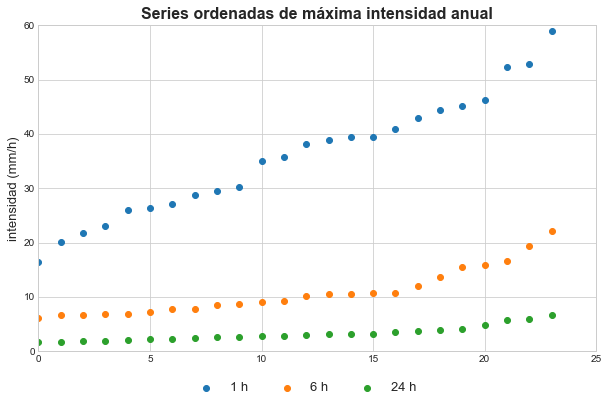

In [3]:
# Configurar el gráfico
fig = plt.figure(figsize=(10, 6))
plt.title('Series ordenadas de máxima intensidad anual', fontsize=16, weight='bold')
plt.xlabel('', fontsize=13)
plt.xlim((0, 25))
plt.ylabel('intensidad (mm/h)', fontsize=13)
plt.ylim((0, 60))

# Tres gráficos de dispersión para cada duración de tormenta
plt.scatter(range(intensity.shape[0]), intensity.sort_values(1)[1], label='1 h')
plt.scatter(range(intensity.shape[0]), intensity.sort_values(6)[6], label='6 h')
plt.scatter(range(intensity.shape[0]), intensity.sort_values(24)[24], label='24 h')

# Leyenda
fig.legend(loc=8, ncol= 3, fontsize=13);

### Ajuste de la función GEV a los datos

Hemos de ajustar una distribución estadística de extremos a los datos. A partir de este ajuste podremos calcular los periodos de retorno. Utilizaremos la función de distribución **GEV (generalized extreme values)**. La función de distribución GEV sigue, para el caso de variables siempre positivas como la precipitación, la siguiente ecuación:

$$F(s,\xi)=e^{-(1+\xi s)^{-1/\xi}}  \quad \forall \xi>0$$
$$ s = \frac{x-\mu}{\sigma} \quad \sigma>0$$

Donde $s$ es la variable de estudio estandarizada a través del parámetro de posición $\mu$ y el parámetro de escala $\sigma$, y $\xi$ es el parámetro de forma. Por tanto, la distribución GEV tiene 3 parámetros. En la siguiente figura se muestra la función de densidad y la función de distribución de extremos del tipo II, la distribución de Frechet, para diversos valores de los parámetros de escala y forma.

<img src="img/Frechet.png" alt="Mountain View" style="width:600px">

Para ajustar la función GEV utilizaremos la función `genextreme.fit` del paquete `SciPy.stats` de Python. Esta función devuelve los valores de los 3 parámetros de la GEV (forma, localización y escala) que mejor se ajustan a nuestros datos.

In [4]:
# Ejemplo
# Ajustar la GEV para duración 1 h
par_int1h = genextreme.fit(intensity[1])

In [5]:
print('Parámetros ajustados para la intensidad en 1 h:')
print('xi =', round(par_int1h[0], 4))
print('mu =', round(par_int1h[1], 4))
print('sigma =', round(par_int1h[2], 4))

Parámetros ajustados para la intensidad en 1 h:
xi = 0.2339
mu = 31.7407
sigma = 10.3977


Lo haremos con un bucle para las tres duraciones (1, 6 y 24 h). Los parámetros se guardarán en el data frame *parametros*.

In [6]:
# Ajustar los parámetros de las 3 duraciones
parametros = pd.DataFrame(index=['xi', 'mu', 'sigma'], columns=D)
for duracion in D:
    # Ajustar la GEV y guardar los parámetros
    parametros[duracion] = genextreme.fit(intensity[duracion])
parametros

,1,6,24
xi,0.233923,-0.396873,-0.235411
mu,31.740658,8.404498,2.540506
sigma,10.397701,2.320138,0.836714


### Curva IDF empírica

La **probabilidad de no excedencia** (el valor de la función de distribución) y el **periodo de retorno** de una variable estan relacionados mediante la siguiente ecuación:

\\[R = \frac{1}{1-CDF(x)}\\]

Donde $R$ es el periodo de retorno en años, y $CDF(x)$ (del inglés, cumulative density function) es el valor de la función de distribución (o probabilidad de no excendencia)  del valor de precipitación $x$.

A partir de esta expresión se pueden calcular los **cuantiles** de un **periodo de retorno** dado:

\\[CDF(x) = \frac{R-1}{R} = 1 - \frac{1}{R}\\]

Analizaremos los periodos de retorno de 10, 25, 50 y 100 años. Calculamos los cuantiles ($Q$) correspondientes a estos periodos de retorno de acuerdo a las distribuciones anteriormente ajustadas.

In [7]:
# Periodos de retorno
R = np.array([10, 25, 50, 100], dtype="float64")

In [8]:
# Probabilidad de no excedencia
Q = 1. - 1. / R

Como ejemplo, generamos los valores extremos de la intensidad de una tormenta de 1 h de duración para las probabilidades de no excedencia (Q). Para ello utilizamos la función `genextrem.ppf` (*percent point function*) del paquete `SciPy.stats`.

In [9]:
# intensidad de 1 h para los periodos de retorno
P1 = genextreme.ppf(Q, *parametros[1]) # ppf: percent point function

print('Intensidad de precipitación en 1 h según periodo de retorno:')
for i, Tr in enumerate(R):
     print('I(Tr=', int(Tr), ') = ', round(P1[i], 1), ' mm/h', sep='')


Intensidad de precipitación en 1 h según periodo de retorno:
I(Tr=10) = 49.9 mm/h
I(Tr=25) = 55.2 mm/h
I(Tr=50) = 58.3 mm/h
I(Tr=100) = 61.0 mm/h


Podemos iterar el cálculo de extremos para cada una de las duraciones y cuantiles, guardando los datos en un *data frame* al que llamaremos *IDF*, el cual podemos graficar.

In [10]:
# data frame con los valores de la curva IDF
IDFe = pd.DataFrame(index=R, columns=D)
IDFe.index.name = 'Tr'
for duracion in D:
    IDFe[duracion] = genextreme(*parametros[duracion]).ppf(Q)
IDFe

,1,6,24
Tr,,,
10.0,49.932830,16.838676,5.023257
25.0,55.155961,23.363122,6.533005
50.0,58.347192,30.062678,7.892088
100.0,61.035854,38.844762,9.483084


In [11]:
# guardar la tabla de resultados
IDFe.to_csv('../output/Ej5_Resultados IDF analítica.csv', float_format='%.1f')

Gráfico de líneas que muestra, para cada periodo de retorno, la intensidad de precipitación en función de la duración de la tormenta. 

Sólo tenemos los datos para tres duraciones de tormenta, motivo por el que la curva es tan quebrada. Para solventar este problema habría que repetir el cálculo para más duraciones de tormenta, o aplicar las **curvas IDF analíticas**.

NameError: name 'IDF' is not defined

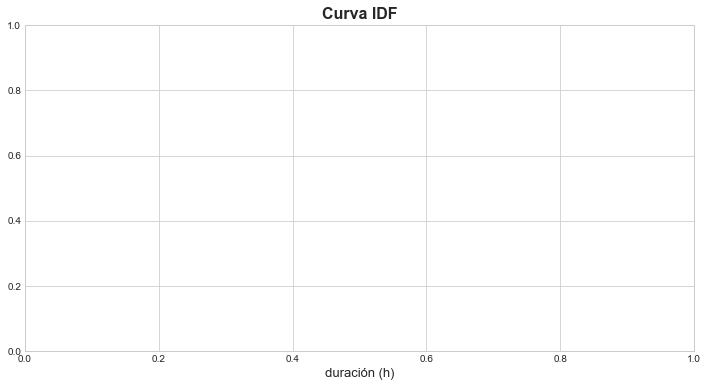

In [12]:
# configuración del gráfico
fig = plt.figure(figsize=(12, 6))
plt.title('Curva IDF', fontsize=16, weight='bold')
plt.xlabel('duración (h)', fontsize=13)
plt.xlim(0, IDF.columns.max() + 1)
plt.ylabel('intensidad (mm/h)', fontsize=13)
plt.ylim((0, 80))
color = ['tan', 'darkkhaki', 'olive', 'darkolivegreen']

for i, Tr in enumerate(IDF.index):
    plt.plot(IDF.loc[Tr,:], color=color[i], label='Tr = ' + str(int(Tr)) + ' años')

fig.legend(loc=8, ncol=4, fontsize=12);

# guardar la figura
plt.savefig('../output/Ej5_IDF empírica.png', dpi=300)

### Curva IDF analítica
Hasta ahora hemos calculado una serie de puntos de la **curva IDF**, los correspondientes a las tormentas de 1, 6 y 24 h para los periodos de retorno de 10, 25, 50 y 100 años. Aplicando las ecuaciones analíticas de la curva IDF, podemos generar la curva completa.

Dos de las formas analíticas de la curva IDF son:

\\[I = \frac{a}{(D + c)^b}\\]

\\[I = \frac{a}{D ^b + c}\\]

donde \\(I\\) es la intensidad de preciptiación, \\(D\\) es la duración de la tormenta, \\(a\\) es una constante dependiente del periodo de retorno y \\(b\\) y \\(c\\) son constantes que dependen de la localización del estudio.

Asumiremos que la relación entre $a$ y el periodo de retorno sigue la siguiente función lineal:

\\[a = d \cdot R + e\\]

Crearemos funciones de Python para estas curvas analíticas.

In [ ]:
def IDF_type_I(x, b, c, d, e):
    """Calcula la intensidad de la precipitación para un periodo de retorno y duración de la tormenta dadas a
    partir de la fórmula I = d * R + e / (D + c)**b.    
    
    Parámetros:
    -----------
    x:         list [2x1]. Par de valores de periodo de retorno(años) y duración (h)
    b:         float. Parámetro de la curva IDF
    c:         float. Parámetro de la curva IDF
    d:         float. Parámetro de la curva IDF
    e:         float. Parámetro de la curva IDF
    
    Salida:
    -------
    I:         float. Intensidad de precipitación (mm/h)"""
    
    a = d * x[0] + e
    I = a / (x[1] + c)**b
    return I

def IDF_type_II(x, b, c, d, e):
    """Calcula la intensidad de la precipitación para un periodo de retorno y duración de la tormenta dadas a
    partir de la fórmula I = d * R + e / (D**b + c).    
    
    Parámetros:
    -----------
    x:         list [2x1]. Par de valores de periodo de retorno(años) y duración (h)
    b:         float. Parámetro de la curva IDF
    c:         float. Parámetro de la curva IDF
    d:         float. Parámetro de la curva IDF
    e:         float. Parámetro de la curva IDF
    
    Salida:
    -------
    I:         float. Intensidad de precipitación (mm/h)"""
    
    a = d * x[0] + e
    I = a / (x[1]**b + c)
    return I

def IDF_type_III(x, b, c, d, e):
    """Calcula la intensidad de la precipitación para un periodo de retorno y duración de la tormenta dadas a
    partir de la fórmula I = d * R**e / (D + c)**b.    
    
    Parámetros:
    -----------
    x:         list [2x1]. Par de valores de periodo de retorno(años) y duración (h)
    b:         float. Parámetro de la curva IDF
    c:         float. Parámetro de la curva IDF
    d:         float. Parámetro de la curva IDF
    e:         float. Parámetro de la curva IDF
    
    Salida:
    -------
    I:         float. Intensidad de precipitación (mm/h)"""
    
    a = d * x[0]**e 
    I = a / (x[1] + c)**b
    return I

def IDF_type_IV(x, b, c, d, e):
    """Calcula la intensidad de la precipitación para un periodo de retorno y duración de la tormenta dadas a
    partir de la fórmula I = d * R**e / (D**b + c).    
    
    Parámetros:
    -----------
    x:         list [2x1]. Par de valores de periodo de retorno(años) y duración (h)
    b:         float. Parámetro de la curva IDF
    c:         float. Parámetro de la curva IDF
    d:         float. Parámetro de la curva IDF
    e:         float. Parámetro de la curva IDF
    
    Salida:
    -------
    I:         float. Intensidad de precipitación (mm/h)"""
    
    a = d * x[0]**e
    I = a / (x[1]**b + c)
    return I 

Para ajustar la curva hemos de crear primero una malla de pares de valores de periodo de retorno y duración. Utilizaremos las tres duraciones ('D') y los cuatro periodos de retorno ('R') ya empleados hasta ahora, para los cuales hemos calculado la intensidad de precipitación asociada (data frame 'IDF').

In [ ]:
# malla con todas las posibles combinaciones de periodo de retorno 'R' y duración 'D'
(RR, DD) = np.meshgrid(R, D)
RR.shape, DD.shape

In [ ]:
# convertir 'RR' y 'DD' en un vector unidimensional
RR = RR.reshape(-1)
DD = DD.reshape(-1)
RR.shape, DD.shape

In [ ]:
# unir los vectores 'RR' y 'DD'
RD = np.vstack([RR, DD])

RD.shape

In [ ]:
# vector unidimensional a partir de 'IDF'
I = np.hstack([IDF[1], IDF[6], IDF[24]])

I.shape

Para ajustar la curva utilizaremos la función `curve_fit` de `SciPy.optimize`. A esta función hemos de asignarle la función de la curva a ajustar, los valores de entrada (pares retorno-duración) y el valor de la función en esos pares (intensidad). La función devuelve un vector con los parámetros de la curva optimizados y otro vector con las covarianza entre dichos parámetros

In [ ]:
# ajustar la curva
curva = IDF_type_IV
popt, pcov = curve_fit(curva, RD, I)

print('Parámetros optimizados de la curva IDF analítica')
for i, par in enumerate(['b', 'c', 'd', 'e']):
    print(par, '=', round(popt[i], 4))

In [ ]:
# guardar parámetros optimizados
IDFa = pd.DataFrame(popt, index=['b', 'c', 'd', 'e']).transpose()
IDFa.to_csv('../output/Ej5_Parámetros IDF analítica.csv', float_format='%.5f')

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.xlim(0, D.max()+1)
plt.xlabel('duración (h)', fontsize=13)
plt.ylabel('intensidad (mm/h)', fontsize=13)
color = ['tan', 'darkkhaki', 'olive', 'darkolivegreen']

xx = np.linspace(.25, D.max(), 1000) # valores de duración
y = np.zeros((xx.size,)) # vector vacío de valores de intensidad

for i, Tr in enumerate(R): # para cada periodo de retorno
    for j, d in enumerate(xx): # para cada duración
        y[j] = curva((Tr, d), *popt)
    # gráfico de línea
    plt.plot(xx, y, color=color[i], label='Tr = ' + str(int(Tr)) + ' años')
    # gráfico de dispersión
    plt.scatter(D, IDF.loc[Tr], s=8, marker='o', c=color[i], label=None)

fig.legend(loc=8, ncol=4, fontsize=12);

# guardar figura
plt.savefig('../output/Ej5_IDF analítica.png', dpi=300)